# Predicting twitter engagement on political documents based on the headline

The following notebook gives some insights in the data and demonstrates the predictability of engagement with tweets based on the headlines of political documents. These are published by the twitter bot at https://twitter.com/hannoverpolitik. We will also investigate if there is particular topic of interest in the group of followers interacting with these tweets.

In [3]:
# do the necessary imports
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

## Reading the data into a pandas dataframe
The data is provided in the sqlite database of the bot an is split in two tables:
* *drucksachen* contains the headlines (titel) of the documents, the publishing date (erscheinungstag), the type of the document (vorlangentyp)
* *engagements* contains the readback of the engagement counters from the twitter API which was done at a particular point in time

To combine engagement parameters with the tweets these tables need to be JOINed.

In [4]:
con = sqlite3.connect("./drucksachen.db")
df = pd.read_sql_query("select d.erscheinungstag, d.vorlangentyp, d.titel, "
                       "e.retweet_count, e.reply_count, e.like_count, e.quote_count "
                       "FROM drucksachen d "
                       "JOIN engagements e ON d.tweetid = e.tweetid", con)

In [5]:
# let's have some quick looks into the data
df.head()

,erscheinungstag,vorlangentyp,titel,retweet_count,reply_count,like_count,quote_count
0,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Ausb...,1,0,0,0
1,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Unte...,0,0,0,0
2,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage Stär...,0,0,0,0
3,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage GS T...,0,0,0,0
4,22.12.2020,Antwort,Antwort der Verwaltung auf die\r\nAnfrage der ...,0,0,0,0


In [6]:
df.describe()

,retweet_count,reply_count,like_count,quote_count
count,5219.000000,5219.000000,5219.000000,5219.000000
mean,0.093121,0.011113,0.100594,0.116497
std,0.315300,0.135183,0.443899,0.332006
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,5.000000,4.000000,13.000000,2.000000


In [5]:
# converting the german date from string to pandas' datetime type
df['erscheinungstag_dt'] = pd.to_datetime(df['erscheinungstag'], dayfirst=True)

In [6]:
# the covered timespan
df['erscheinungstag_dt'].min(), df['erscheinungstag_dt'].max()

(Timestamp('2020-12-22 00:00:00'), Timestamp('2022-02-09 00:00:00'))

## How is the activity distributed over the year?
The following plot shows the number of tweets grouped by calendar week.

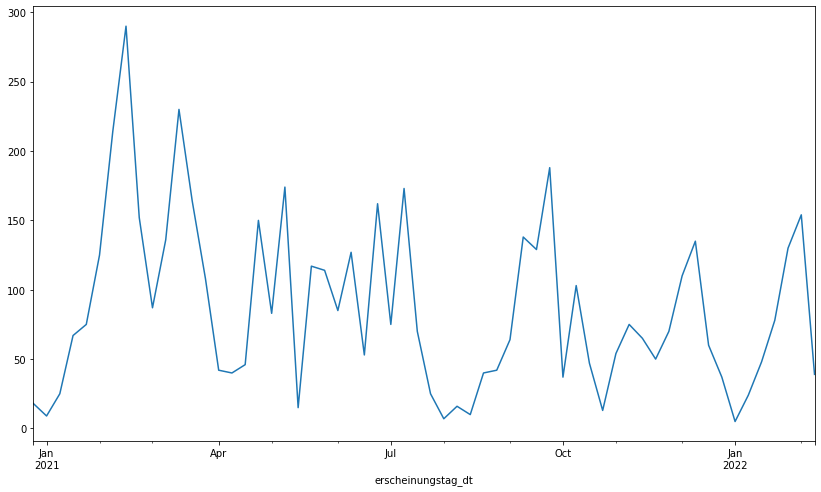

In [7]:
df.groupby([pd.Grouper(key='erscheinungstag_dt', freq='W-MON')]).count()['titel'].plot(figsize=(14,8));

# How to measure engagement
Does it make sense to predict the level of engagement by regression or shall we use a classification: engagement or not. Let's calculate the total number of engagemets and plot an overview of engagements in the dataset.

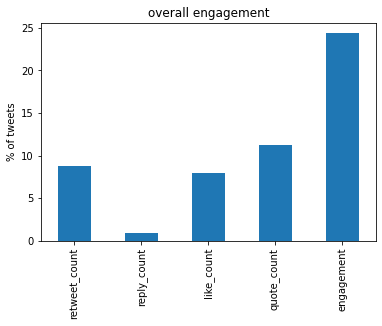

In [9]:
# calculate the total number of engagements
df['engagement'] = df['retweet_count'] + df['reply_count'] + df['like_count'] + df['quote_count']
# plot overview
numerics = ['retweet_count', 'reply_count', 'like_count', 'quote_count', 'engagement']
(df[numerics][df[numerics] > 0].count() / len(df) * 100).plot.bar(ylabel='% of tweets', title='overall engagement');

Do the different types of engagement correlate?

In [10]:
df[['retweet_count', 'reply_count', 'like_count', 'quote_count']].corr()

,retweet_count,reply_count,like_count,quote_count
retweet_count,1.000000,0.182543,0.312345,-0.026761
reply_count,0.182543,1.000000,0.243248,0.069358
like_count,0.312345,0.243248,1.000000,0.148032
quote_count,-0.026761,0.069358,0.148032,1.000000


At least for the likes we see some correlation with the other interactions. But we can't say that one engagement represents them all. Let's look into the number of retweets over time as an example.

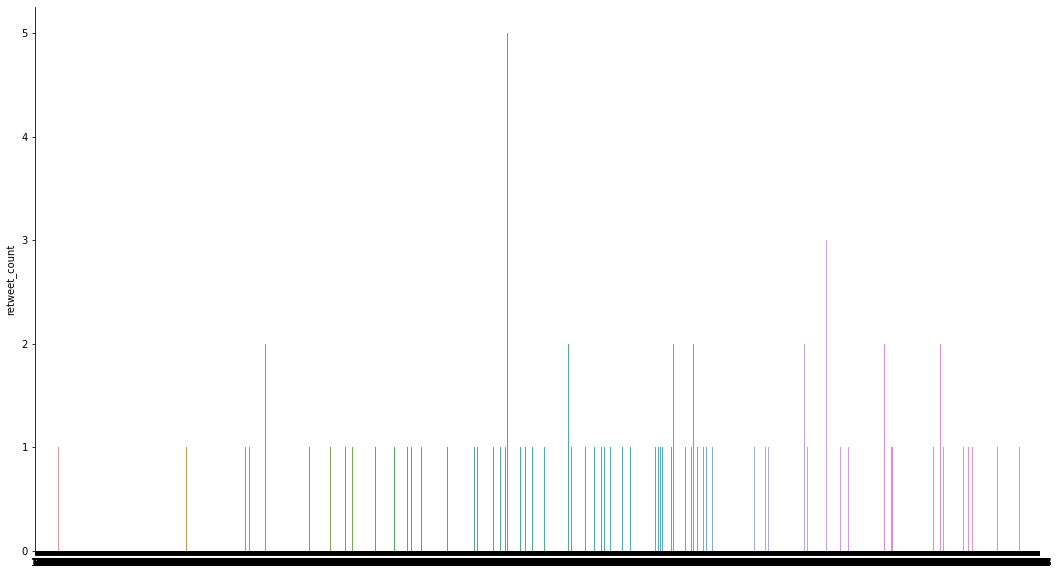

In [11]:
fig, ax1 = plt.subplots(figsize=(18, 10))
sns.barplot(data=df, x=df.index, y="retweet_count", ax=ax1)
sns.despine(fig)

There is not enough data for the higher number of retweets to allow a regression based on retweets. Next idea is to simply calculate the total of engagements and plot it over time. Let's look into the total engagements over time:

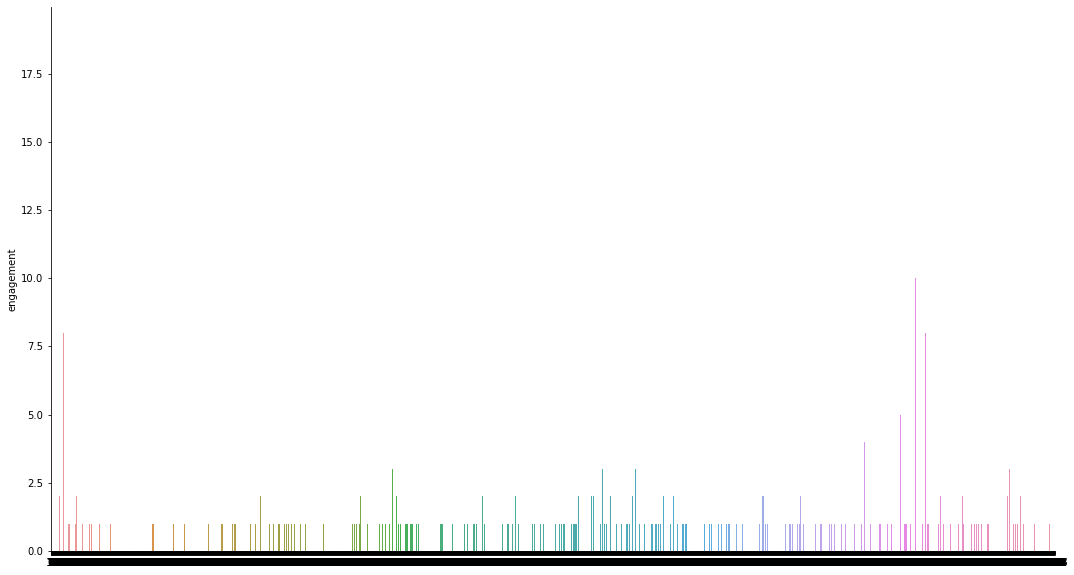

In [13]:
fig, ax1 = plt.subplots(figsize=(18, 10))
sns.barplot(data=df, x=df.index, y="engagement", ax=ax1)
sns.despine(fig)

Also in this plot we get the impression that most tweets have only one engagement some have two, the others could be considered outliers. Hence there is not enough data for a regression. This is also confirmed by a cumulative distribution of the engagements of the tweets as follows:

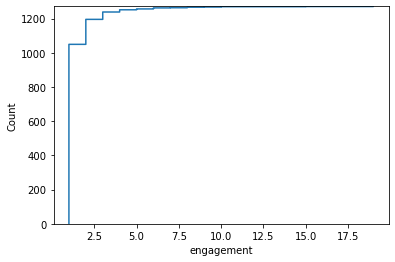

In [14]:
sns.ecdfplot(df['engagement'][df['engagement'] > 0], stat="count");

## Does the type of the document correlate with the engagement
Let's create some insights first

In [15]:
# which document types exist?
df['vorlangentyp'].unique()

array(['Antwort', 'Neufassung', 'Beschlussdrucksache',
       'Informationsdrucksache', 'Anfrage', 'Entscheidung', 'Antrag',
       'Ergänzung', 'Haushaltsantrag', 'Stellungnahme'], dtype=object)

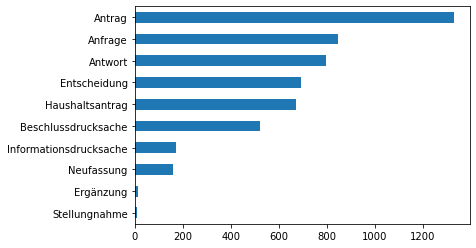

In [16]:
# how many of each type do we have in the dataset?
df['vorlangentyp'].value_counts(ascending=True).plot.barh();

In [17]:
# what is the relative activity by type of document?
df[['vorlangentyp'] + numerics].groupby('vorlangentyp').mean()

,retweet_count,reply_count,like_count,quote_count,engagement
vorlangentyp,,,,,
Anfrage,0.135613,0.017689,0.146226,0.113208,0.412736
Antrag,0.124247,0.016566,0.118223,0.167922,0.426958
Antwort,0.072682,0.015038,0.098997,0.112782,0.299499
Beschlussdrucksache,0.030651,0.001916,0.040230,0.045977,0.118774
Entscheidung,0.148415,0.010086,0.155620,0.182997,0.497118
Ergänzung,0.357143,0.071429,0.357143,0.142857,0.928571
Haushaltsantrag,0.002972,0.000000,0.013373,0.017831,0.034175
Informationsdrucksache,0.034884,0.000000,0.040698,0.075581,0.151163
Neufassung,0.081250,0.000000,0.093750,0.131250,0.306250


Seems there is particularly high activity on the amendmend (Ergänzung) but that is an artefact as there are only 14 amendmends in the dataset:

In [18]:
df[['vorlangentyp'] + numerics].groupby('vorlangentyp').count()

,retweet_count,reply_count,like_count,quote_count,engagement
vorlangentyp,,,,,
Anfrage,848,848,848,848,848
Antrag,1328,1328,1328,1328,1328
Antwort,798,798,798,798,798
Beschlussdrucksache,522,522,522,522,522
Entscheidung,694,694,694,694,694
Ergänzung,14,14,14,14,14
Haushaltsantrag,673,673,673,673,673
Informationsdrucksache,172,172,172,172,172
Neufassung,160,160,160,160,160


In [19]:
# why do we have such a high activity on the amendmend (Ergänzung)?
df[df['vorlangentyp'] == 'Ergänzung']

,erscheinungstag,vorlangentyp,titel,retweet_count,reply_count,like_count,quote_count,erscheinungstag_dt,engagement
63,13.01.2021,Ergänzung,Ausbau der Lutherstraße zwischen Sallstraße un...,1,0,0,0,2021-01-13,1
125,19.01.2021,Ergänzung,Programmdrucksache zu den Infrastrukturmaßnahm...,0,0,0,0,2021-01-19,0
1221,10.03.2021,Ergänzung,1. Ergänzung zum Verwaltungsentwurf des Hausha...,0,0,0,0,2021-03-10,0
1436,16.03.2021,Ergänzung,2. Ergänzung zum Verwaltungsentwurf des Hausha...,0,0,0,0,2021-03-16,0
1702,30.03.2021,Ergänzung,\r\n1. Ergänzung zur Drucksache Nr. 0629/2021 ...,0,0,0,0,2021-03-30,0
2009,28.04.2021,Ergänzung,Änderungsanträge des Stadtbezirksrates Linden-...,0,0,0,0,2021-04-28,0
2060,30.04.2021,Ergänzung,Bushaltestelle „Kröpcke“ und Fahrbahnerneuerun...,0,0,0,0,2021-04-30,0
2377,26.05.2021,Ergänzung,Ausbau der Veloroute 08 aus der Innenstadt Han...,0,0,0,1,2021-05-26,1
2623,10.06.2021,Ergänzung,Antwort der Verwaltung auf die\r\nAnfrage Aufp...,1,0,0,0,2021-06-10,1
2723,18.06.2021,Ergänzung,"Bebauungsplan der Innenentwicklung Nr. 473, 2....",0,0,0,0,2021-06-18,0


Tweet 4327 received an outstanding high engagement which creates a bias towards this small group of this type.

## Prepare the title (titel) column for training a model
We use a CountVectorizer for converting the text into a frequency matrix. This involves a list of stopwords of the german language and a custom preprocessor which drops number words like 02 2022, etc. These origin from dates mentioned in the titles. The vectorizer has been configured to drop words which occur more often than 15% and less than 0.1% as they won't contribute much to the result. 

In [8]:
# stopwords from https://github.com/stopwords-iso/stopwords-de
stopwords = pd.read_table("./stopwords-de.txt", header=None)
stopwords = stopwords[0].values.tolist()

In [9]:
# tryout the CountVectorizer with a sample of the dataset
testset = df.sample(20)

# get rid of numbers as words which are derived from dates
def preprocess_text(text):
    """
    Custom text preprocessor.
    
    For usage in CountVectorizer. Converts text to lowercase and removes words which only contain digits.
    
    Parameters:
    arg1 (string): Input text
    
    Returns:
    string: Processed text
    """
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

vectorizer = CountVectorizer(stop_words=stopwords, 
                             preprocessor=preprocess_text,
                             max_df=0.15, min_df=0.001)
vectorizer.fit_transform(testset['titel'])

<20x109 sparse matrix of type '<class 'numpy.int64'>'
	with 120 stored elements in Compressed Sparse Row format>

In [22]:
vectorizer.get_feature_names_out()

array(['ahlem', 'al', 'antrag', 'aschubi', 'aufstellungsbeschluss',
       'badenstedt', 'ballhause', 'baugenehmigungsverfahren',
       'bebauungsplan', 'beleuchtung', 'benennung', 'berggartenstr',
       'beschluss', 'beteiligung', 'bezug', 'bildungsausschusses',
       'brücke', 'buchholz', 'bündnis', 'bürgerpanel', 'cdu',
       'davenstedt', 'deutliche', 'dringlichkeitsantrag', 'ds',
       'durchführung', 'eberhard', 'eggers', 'einleitungsbeschluss',
       'einrichtung', 'einzelhandelsmärkte', 'elternvertretung', 'et',
       'fahrzeuge', 'fdp', 'fortsetzung', 'fraktion', 'frühzeitigen',
       'fußgängerweg', 'garkenburgstraße', 'gartenstraße', 'gehweg',
       'gemäß', 'geändert', 'graffiti', 'gruppe', 'grünen',
       'hanomagstraße', 'hohen', 'hoher', 'hundetütenspender', 'höhe',
       'innenentwicklung', 'kantplatz', 'kindergartengruppe',
       'kindertagesstätte', 'kleefeld', 'ladestationen',
       'landesrechnungshof', 'ledeburg', 'linke', 'markierung',
       'maschse

In [23]:
# apply the vectorizer to the entire dataset
X = vectorizer.fit_transform(df['titel'])
X.shape

(5219, 849)

In [24]:
# create a dataframe from the sparse matrix for inspection
display(vectorizer.get_feature_names_out().shape)
X_df = pd.DataFrame(X.todense(), columns=vectorizer.get_feature_names_out())

(849,)

In [25]:
# show the top counted words for adjusting max_df of the vectorizer
X_df.sum().sort_values(ascending=False).head(20)

teilhaushalt       700
produkt            570
fraktion           384
nr                 353
hannover           336
straße             315
stadtbezirk        313
änderungsantrag    249
wülferode          230
mitte              224
bemerode           223
kirchrode          221
entscheidung       219
misburg            216
anderten           205
limmer             194
bothfeld           180
vahrenheide        178
antrag             176
döhren             172
dtype: int64

In [26]:
# show the least counting words for adjusting min_df of the vectorizer
X_df.sum().sort_values(ascending=True).head(20)

entwicklung        6
sitzungen          6
kleefelder         6
erhebung           6
seilbahn           6
seelhorster        6
schwule            6
ersetzt            6
schulergänzende    6
scholz             6
schafbrinke        6
sau                6
sandberge          6
feind              6
route              6
rotfärbung         6
ffp                6
frauen             6
freien             6
radfahrende        6
dtype: int64

In [27]:
# split out the classification
y = df['engagement'].apply(lambda x: 1 if x > 0 else 0)
y

0       1
1       0
2       0
3       0
4       0
       ..
5214    0
5215    0
5216    0
5217    0
5218    0
Name: engagement, Length: 5219, dtype: int64

In [28]:
# put this through a TfidfTransformer which isn't necessarry for the random forest but other classifiers have been tried
scaler = TfidfTransformer()
X_scaled = scaler.fit_transform(X)
# split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

## Calculate a baseline from an informed random guess
To decide if our model is better than just random guessing we set up a random_prediction of the same size as the test set. This can be used to comparing the model's metrics against. The random guess is "informed" as it reproduces the likelihood of finding an engagement from the entire dataset.

In [29]:
ratio_of_engaged = y.sum() / len(y)
len_of_prediction = len(y_test)
number_of_engaged_in_prediction = int(len_of_prediction * ratio_of_engaged)
random_prediction = np.zeros(len_of_prediction)
# draw some random indices for engaged in random predictionn
indexes = np.random.choice(len_of_prediction, number_of_engaged_in_prediction, replace=False)
random_prediction[indexes] = 1
random_prediction.sum(), len(random_prediction)

(381.0, 1566)

## Fit and evaluate the model

In [30]:
model = RandomForestClassifier()
#model = AdaBoostClassifier()
#model = DecisionTreeClassifier(max_depth=15, min_samples_split=30, min_samples_leaf=5)
model.fit(X_train, y_train)

RandomForestClassifier()

In [11]:
# this helper function prints the model's performance
def print_scores(test, pred, title):
    """
    Print model evaluation.
    
    Prints accuracy, precision, recall and the number of predictions plus a confusion matrix.
    
    Parameters:
    arg1 (array-like): true classifier
    arg2 (array-like): predicted classifier
    arg3 (string): title for print and plot
    """
    print('==== ', title, ' ====')
    print('accuracy', accuracy_score(test, pred))
    print('precision', precision_score(test, pred))
    print('recall', recall_score(test, pred))
    print('number of predictions ', len(pred))
    display(confusion_matrix(test, pred, normalize='all'))
    disp = ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=('no engagement', 'engagement'))
    disp.ax_.set_title(title)

====  Testset  ====
accuracy 0.8167305236270753
precision 0.6689655172413793
recall 0.5038961038961038
number of predictions  1566


array([[0.69284802, 0.06130268],
       [0.12196679, 0.1238825 ]])

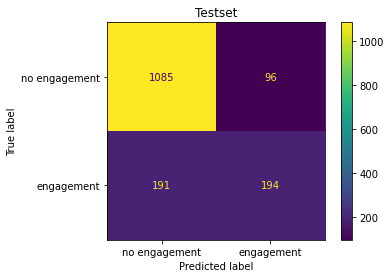

In [32]:
y_pred = model.predict(X_test)
print_scores(y_test, y_pred, 'Testset')


====  Trainingset  ====
accuracy 0.953462907199562
precision 0.9578005115089514
recall 0.845372460496614
number of predictions  3653


array([[0.74842595, 0.00903367],
       [0.03750342, 0.20503696]])

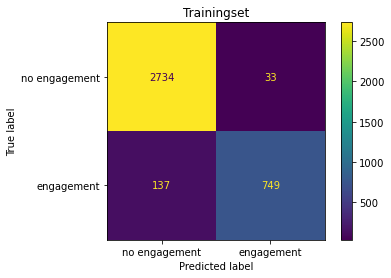

In [33]:
y_train_pred = model.predict(X_train)
print_scores(y_train, y_train_pred, 'Trainingset')

====  Informed random guess  ====
accuracy 0.6411238825031929
precision 0.2677165354330709
recall 0.2649350649350649
number of predictions  1566


array([[0.57598978, 0.17816092],
       [0.1807152 , 0.0651341 ]])

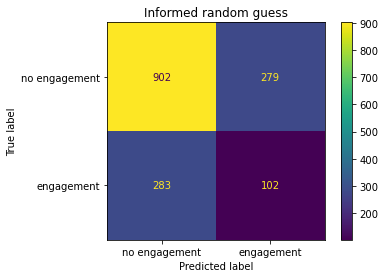

In [34]:
print_scores(y_test, random_prediction, 'Informed random guess')

## Can we identify an area of interest in the tweets which gain an engagement?
To gain some insight into the model we evaluate the feature importances reported by the random forest model and map them to the corresponding words from the frequency matrix.

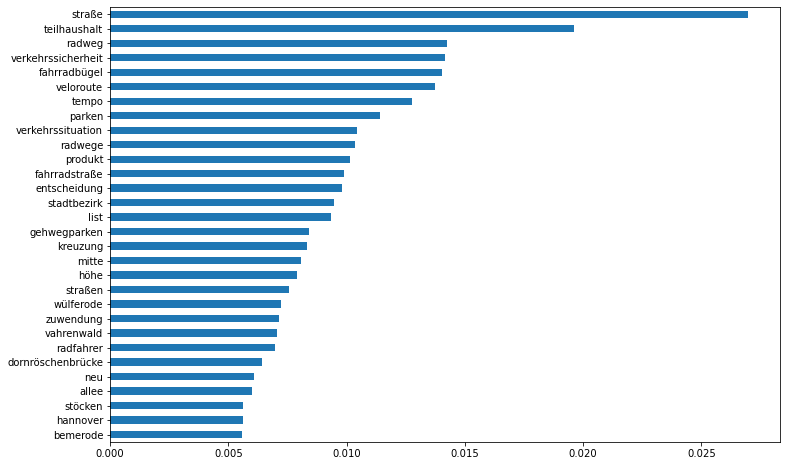

In [35]:
importance = pd.Series(model.feature_importances_, index=vectorizer.get_feature_names_out())
importance.sort_values(ascending=True).tail(30).plot.barh(figsize=(12,8));

This indicates that words concerning traffic and bike traffic in particular are important for making a prediction about engagements. The random forest model doesn't give us an indication about the direction a word is pointing concerning the prediction as the random forest works on word combinations, so the model is more complex than that.

Nevertheless we might get an idea about a direction if we look into a correlation among the words and the classification as a linear model would do. The following plot of the correlation between the top 30 words shown above and the engagement classifier encourages the finding that traffic and bike traffic is a topic which causes engagement on these tweets.

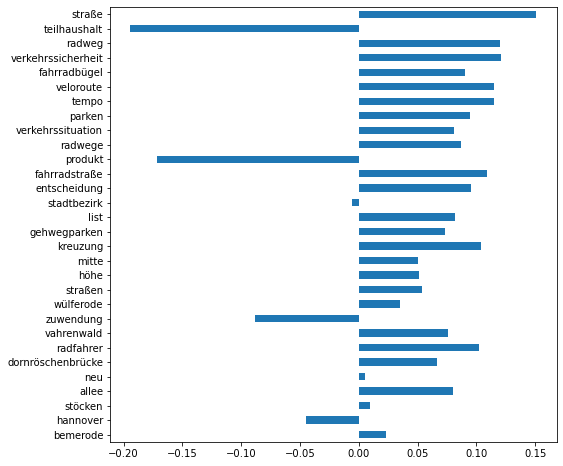

In [36]:
feature_names = vectorizer.get_feature_names_out()
top30features = importance.argsort()[-30:]
important_df = pd.DataFrame(X[:,top30features].toarray(), columns=feature_names[top30features])
important_df['engagement'] = y
important_df.corr()['engagement'].drop('engagement').plot.barh(figsize=(8,8));